In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ubuntu


In [6]:
from copy import deepcopy
from typing import Any

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from acnportal.acnsim.network.sites import caltech_acn, jpl_acn

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_SCALING_FACTOR
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv
from sustaingym.envs.evcharging.event_generation import RealTraceGenerator, GMMsTraceGenerator

from sustaingym.algorithms.evcharging.base_algorithm import SelectiveChargingAlgorithm, GreedyAlgorithm

In [11]:
# Initialize gym
generator = RealTraceGenerator(site='caltech', date_range=('2018-11-05', '2018-11-11'), sequential=True, period=5)
eval_env = EVChargingEnv(generator, action_type='discrete')

In [45]:
from datetime import datetime, timedelta
import pandas as pd

DATE_FORMAT = "%Y-%m-%d"

# algs = [SelectiveChargingAlgorithm(rate=0.0), SelectiveChargingAlgorithm(rate=1.0), GreedyAlgorithm()]
algs = [GreedyAlgorithm()]

def collect_rewards(env, algs):
    # begin = datetime.strptime(env.date_range[0], DATE_FORMAT)
    # end = datetime.strptime(env.date_range[1], DATE_FORMAT)
    # days_diff = end - begin
    # num_days_sim = days_diff.days + 1

    results = {}
    for alg in algs:
        results[alg] = alg.run(env, 1) # num_days_sim
    results = {alg.name: reward for alg, reward in results.items()}

    print(results)

    # results['dates'] = [begin + timedelta(days=i) for i in range(num_days_sim)]

    # results = pd.DataFrame(results)
    # results.set_index('dates', inplace=True)
    # return results

heuristics_rewards = collect_rewards(eval_env, algs)
heuristics_rewards

Simulating day 2018-11-05 with 42 plug in events. 
abs([[ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   8.66025388e-01+0.5j         8.66025388e-01+0.5j
   8.66025388e-01+0.5j         8.66025388e-01+0.5j
   8.66025388e-01+0.5j         8.66025388e-01+0.5j
   8.66025388e-01+0.5j         8.66025388e-01+0.5j
   0.00000000e+00-0.j          0.00000000e+00-0.j
   0.00000000e+00-0.j          0.00000000e+00-0.j
   0.00000000e+00-0.j          0.00000000e+00-0.j
   0.00000000e+00-0.j          0.00000000e+00-0.j
   0.00000000e+00-0.j          0.00000000e+00-0.j
   0.00000000e+00-0.j          0.00000000

AssertionError: 

In [44]:
# Initialize gym
generator = RealTraceGenerator(site='caltech', date_range=('2018-11-05', '2018-11-11'), sequential=True, period=5)
env = EVChargingEnv(generator, action_type='discrete')

observation = env.reset()

for _ in range(150):
    observation, _, _, _ = env.step(np.zeros((54,)))

num_stations = observation['demands'].shape[0]
r = cp.Variable(num_stations)
A = observation['constraint_matrix']
phase_factor = np.exp(1j * np.deg2rad(observation['phases']))
A_tilde = A * phase_factor[None, :]
agg_current_complex = A_tilde @ r
agg_magnitude = cp.abs(agg_current_complex)

print(observation['demands'] / 8)

objective = cp.Minimize(cp.norm(observation['demands'] / 8 - r, p=1))
constraints = [0 <= r, r <= 4, agg_magnitude <= observation['magnitudes'] / 8]

prob = cp.Problem(objective, constraints)

optimal = prob.solve(solver='ECOS')

print(r.value)


[  0.         0.         0.         0.         0.         0.
  43.26923    0.         0.         0.         0.         0.
   0.       259.6154   115.38461    0.         0.         0.
   0.         0.         0.         0.         0.       115.38461
 173.07692    0.         0.        57.692307   0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.      ]
[5.34303703e-10 5.34303703e-10 5.34303703e-10 5.34303703e-10
 5.34303703e-10 5.34303703e-10 4.00000000e+00 5.34303703e-10
 5.34303703e-10 5.34303703e-10 5.98940317e-10 5.98940317e-10
 5.98940317e-10 4.00000000e+00 4.00000000e+00 5.98940317e-10
 5.98940317e-10 5.98940317e-10 7.02823179e-10 7.02823179e-10
 7.02823179e-10 7.02823179e-10 7.02823179e-10 4.00000000e+00
 4.00000000e+00 7.02823179e-10 5.08542163e-10 4.00000000e+00
 5.08542163e

In [15]:

r = cp.Variable(54)
print(r.value)
acn = caltech_acn()
A = acn.constraint_matrix
phase_factor = np.exp(1j * np.deg2rad(observation['phases']))
A_tilde = A * phase_factor[None, :]
agg_current_complex = A_tilde @ r
agg_magnitude = cp.abs(agg_current_complex)

# demands = cp.Parameter(54)
demands = observation['demands']
# print("demand val: ", demands.value)

objective = cp.Minimize(cp.norm(r - demands, p=1))
constraints = [0 <= r, r <= MAX_ACTION, agg_magnitude <= observation['magnitudes'] / 8]

prob = cp.Problem(objective, constraints)
print("Is DPP? ", prob.is_dcp(dpp=True))
print("Is DCP? ", prob.is_dcp(dpp=False))

demand_vals = [np.random.rand(54) * i for i in range(10)]
i = 0
for demand in demand_vals:
    i += 1
    print(i)
    demands.value = demand
    optimal = prob.solve(solver='ECOS')
print(r.value)


None


NameError: name 'observation' is not defined

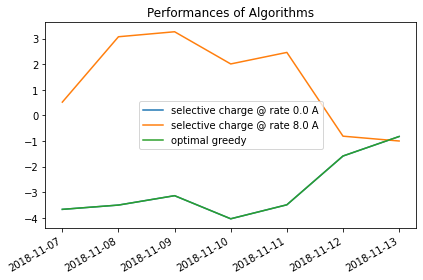

In [18]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards.columns:
    plt.plot(heuristics_rewards[col], label=col)
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


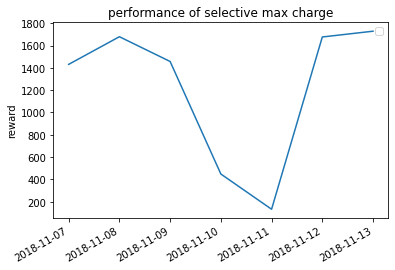

In [14]:
plt.title("performance of selective max charge")
plt.ylabel("reward")
plt.gcf().autofmt_xdate()
plt.legend()
plt.plot(heuristics_rewards['selective max charge'])

In [ ]:
# rewards

,selective max charge,no charge,constraint violator,random
dates,,,,
2018-11-07,1431.09619,-108.953704,-58726.430027,-27413.866995
2018-11-08,1678.92414,-108.568519,-57124.640764,-25530.657384
2018-11-09,1456.96505,-90.009259,-58225.706817,-26381.695055


In [16]:
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from sustaingym.envs.evcharging.ev_charging import EVChargingEnv

In [18]:
train_env = EVChargingEnv('caltech', date_range, real_traces=True, sequential=False)
model = PPO('MultiInputPolicy', train_env, verbose=0)
rl_algo = RLAlgorithm(model)

untrained_rewards = collect_rewards(eval_env, [rl_algo])
display(untrained_rewards)

trained_rewards = {}
num_steps = 0
timesteps = 25_000

for _ in range(10):
    num_steps += timesteps
    model.learn(total_timesteps=timesteps)
    print("num timesteps: ", num_steps)
    trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
    display(trained_rewards[num_steps])

Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-27530.233596
2018-11-08,-26047.986816
2018-11-09,-26434.360625
2018-11-10,-30464.663646
2018-11-11,-31166.443874
2018-11-12,-25693.945429
2018-11-13,-27104.763353


num timesteps:  25000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-27210.780528
2018-11-08,-25424.398539
2018-11-09,-26485.943181
2018-11-10,-31014.131744
2018-11-11,-31517.118967
2018-11-12,-25670.840024
2018-11-13,-26585.789181


num timesteps:  50000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-26449.112370
2018-11-08,-25341.236395
2018-11-09,-26121.286323
2018-11-10,-30365.825143
2018-11-11,-30672.264089
2018-11-12,-25134.284622
2018-11-13,-26399.164671


num timesteps:  75000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-25719.429307
2018-11-08,-24756.350340
2018-11-09,-24815.185972
2018-11-10,-30420.338540
2018-11-11,-30227.014825
2018-11-12,-24717.078957
2018-11-13,-25790.296901


num timesteps:  100000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-26013.620269
2018-11-08,-24561.957645
2018-11-09,-24951.247720
2018-11-10,-29071.180484
2018-11-11,-29810.962631
2018-11-12,-24145.949549
2018-11-13,-25392.969390


num timesteps:  125000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-25224.688211
2018-11-08,-23488.130032
2018-11-09,-24138.268581
2018-11-10,-28810.354616
2018-11-11,-28950.493756
2018-11-12,-23583.235713
2018-11-13,-24259.598087


num timesteps:  150000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-23993.993815
2018-11-08,-23316.609759
2018-11-09,-23153.397749
2018-11-10,-27980.152506
2018-11-11,-27790.763374
2018-11-12,-22610.599186
2018-11-13,-24126.960454


num timesteps:  175000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-24117.083515
2018-11-08,-22425.575392
2018-11-09,-22824.705020
2018-11-10,-27736.258273
2018-11-11,-27214.135561
2018-11-12,-22662.364189
2018-11-13,-23150.691522


num timesteps:  200000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-23755.167101
2018-11-08,-22126.012924
2018-11-09,-23065.919416
2018-11-10,-26965.282889
2018-11-11,-27122.395302
2018-11-12,-22651.175911
2018-11-13,-22994.597284


num timesteps:  225000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-22891.897621
2018-11-08,-21833.364353
2018-11-09,-22377.590673
2018-11-10,-27010.515631
2018-11-11,-26565.737940
2018-11-12,-22017.638439
2018-11-13,-22575.232658


num timesteps:  250000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-22830.688014
2018-11-08,-21372.616705
2018-11-09,-22519.725936
2018-11-10,-27087.002432
2018-11-11,-26481.058160
2018-11-12,-21593.053190
2018-11-13,-21856.075044
